In [1]:
# Import necessary libraries for data handling, plotting, and deep learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical



In [2]:
# Function to load and preprocess audio data by extracting features (MFCCs)
def load_and_preprocess_data(audio_path, label):
    # Load the audio file and set sample rate to None to keep it original
    audio, sr = librosa.load(audio_path, sr=None)
    
    # Extract MFCC (Mel-frequency cepstral coefficients) features, often used in audio analysis
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    # Transpose MFCCs to shape them correctly for model input
    return mfccs.T, label

# Function to prepare dataset from real and fake audio file paths
def prepare_dataset(real_paths, fake_paths):
    X, y = [], []  # X will hold features, y will hold labels (0 for real, 1 for fake)
    
    # Load real audio files and label them as 0 (real)
    for path in real_paths:
        features, label = load_and_preprocess_data(path, 0)
        X.append(features)
        y.append(label)
    
    # Load fake audio files and label them as 1 (fake)
    for path in fake_paths:
        features, label = load_and_preprocess_data(path, 1)
        X.append(features)
        y.append(label)
    
    # Return features (X) and labels (y) as numpy arrays for model compatibility
    return X, np.array(y)


In [3]:
# Function to apply data augmentation techniques to the dataset
def augment_data(X, y):
    augmented_X, augmented_y = [], []
    
    # Loop through each feature set and label
    for features, label in zip(X, y):
        augmented_X.append(features)  # Original features
        augmented_y.append(label)    # Original label
        
        # Time stretching (simulate by adjusting audio speed before extracting features)
        audio_signal = librosa.effects.time_stretch(features.T[0], rate=0.8)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)
        
        # Pitch shifting (change pitch slightly for diversity in data)
        audio_signal_shifted = librosa.effects.pitch_shift(features.T[0], sr=22050, n_steps=2)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal_shifted, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)
    
    # Return augmented features and labels
    return augmented_X, np.array(augmented_y)


In [4]:
# Function to create an LSTM-based model
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [5]:
# Function to train and evaluate the model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    # Train the model and store the training history for plotting
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.2, 
                        verbose=1)
    
    # Evaluate the model on test data and print test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Return the training history to analyze learning progress
    return history


In [6]:
# Function to visualize training and validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [8]:
import os

base_path = "data\KAGGLE\AUDIO"

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Masking


In [9]:
real_paths = [os.path.join(base_path, "REAL", f) for f in os.listdir(os.path.join(base_path, "REAL")) if f.endswith('.wav')]
fake_paths = [os.path.join(base_path, "FAKE", f) for f in os.listdir(os.path.join(base_path, "FAKE")) if f.endswith('.wav')]

# Prepare and augment the dataset
X, y = prepare_dataset(real_paths, fake_paths)
X_augmented, y_augmented = augment_data(X, y)

# Pad sequences
# max_length = max(len(seq) for seq in X_augmented)
# max_length = int(np.percentile([len(seq) for seq in X_augmented], 75))
max_length = 500
X_padded = pad_sequences(X_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_augmented, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Create and train the model
model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = train_and_evaluate(model, X_train, y_train, X_test, y_test)


Epoch 1/50
4/4 [==============================] - 18s 1s/step - loss: 0.5455 - accuracy: 0.8361 - val_loss: 0.4741 - val_accuracy: 0.8710
Epoch 2/50
4/4 [==============================] - 0s 127ms/step - loss: 0.4519 - accuracy: 0.8770 - val_loss: 0.4227 - val_accuracy: 0.8710
Epoch 3/50
4/4 [==============================] - 0s 128ms/step - loss: 0.4012 - accuracy: 0.8852 - val_loss: 0.3946 - val_accuracy: 0.8710
Epoch 4/50
4/4 [==============================] - 0s 122ms/step - loss: 0.3666 - accuracy: 0.8852 - val_loss: 0.3867 - val_accuracy: 0.8710
Epoch 5/50
4/4 [==============================] - 0s 114ms/step - loss: 0.3589 - accuracy: 0.8852 - val_loss: 0.3871 - val_accuracy: 0.8710
Epoch 6/50
4/4 [==============================] - 0s 116ms/step - loss: 0.3620 - accuracy: 0.8852 - val_loss: 0.3906 - val_accuracy: 0.8710
Epoch 7/50
4/4 [==============================] - 0s 129ms/step - loss: 0.3580 - accuracy: 0.8852 - val_loss: 0.3926 - val_accuracy: 0.8710
Epoch 8/50
4/4 [======

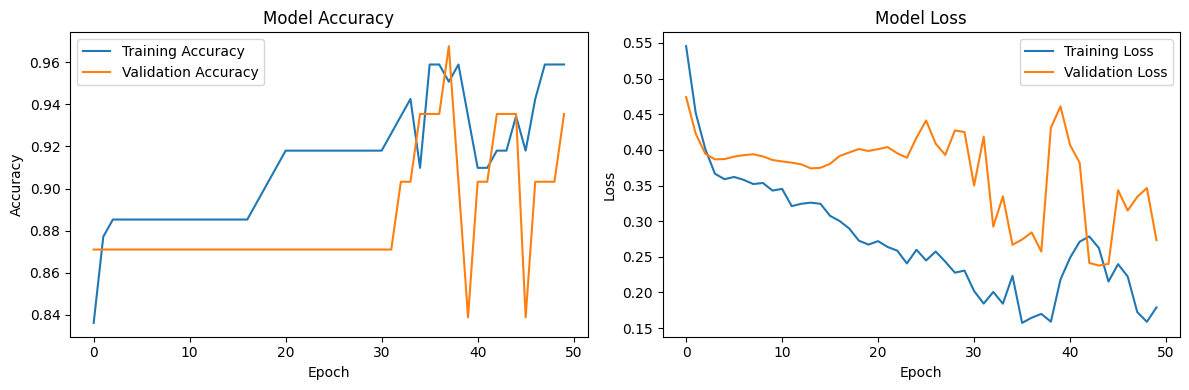

2/2 [==============================] - 4s 83ms/step


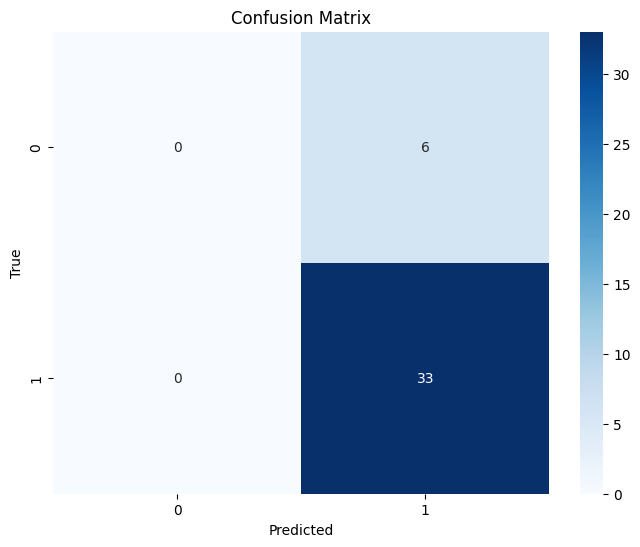

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.85      1.00      0.92        33

    accuracy                           0.85        39
   macro avg       0.42      0.50      0.46        39
weighted avg       0.72      0.85      0.78        39



c:\Users\60165\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\60165\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\60165\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [13]:
# Visualize the results
plot_training_history(history)

y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


In [14]:
def preprocess_audio(audio_path, max_length):
    # Load the audio
    audio, sr = librosa.load(audio_path, sr=None)
    
    # Extract MFCC features (use same parameters as training)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    # Transpose the MFCCs to match the input format
    mfccs = mfccs.T

    # Pad the sequence to the max length used during training
    padded_mfccs = pad_sequences([mfccs], maxlen=max_length, dtype='float32', padding='post', truncating='post')

    return padded_mfccs


In [20]:
test_audio_paths = [
    r'data\KAGGLE\AUDIO\FAKE\trump-to-taylor.wav', 
    r'data\real life test audio\human voice 1.wav'
]

for audio_path in test_audio_paths:
    padded_sample = preprocess_audio(audio_path, max_length=X_train.shape[1])
    prediction = model.predict(padded_sample)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class]  # Confidence score for the predicted class

    if predicted_class == 1:
        print(f"{audio_path}: Fake (Confidence: {confidence:.2f})")
    else:
        print(f"{audio_path}: Real (Confidence: {confidence:.2f})")


1/1 [==============================] - 0s 104ms/step
data\KAGGLE\AUDIO\FAKE\trump-to-taylor.wav: Fake (Confidence: 0.99)
1/1 [==============================] - 0s 66ms/step
data\real life test audio\human voice 1.wav: Fake (Confidence: 0.99)
